## 1. installing requirements

In [3]:
!pip install opencv-python 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 143.5 kB/s eta 0:00:0000:0100:08


In [7]:
!pip install matplotlib

## 2. importing 

In [45]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np

In [13]:
import cv2
import imghdr

## 3. getting the data right

In [43]:
data_dir = 'data'
os.listdir(data_dir)

['happy', 'sad']

In [15]:
image_ext = ['jpeg','jpg','bmp','png']

In [24]:
img = cv2.imread(os.path.join('data','happy','what-makes-people-happy.jpeg'))

In [21]:
img.shape

(1000, 1500, 3)

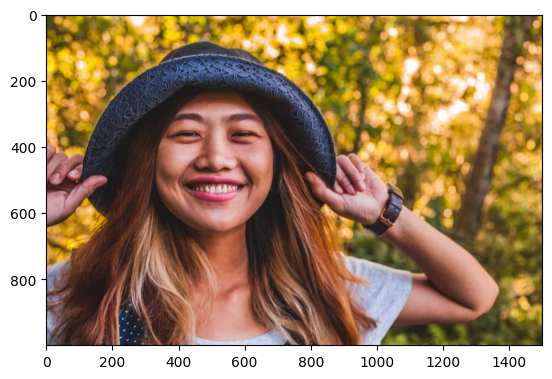

In [23]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [46]:
## removing unwanted images
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_ext:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')

## 4. loading data

In [47]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [153]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=32)

Found 305 files belonging to 2 classes.


In [154]:
data_iterator = data.as_numpy_iterator()

In [155]:
batch = data_iterator.next()

In [156]:
# images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

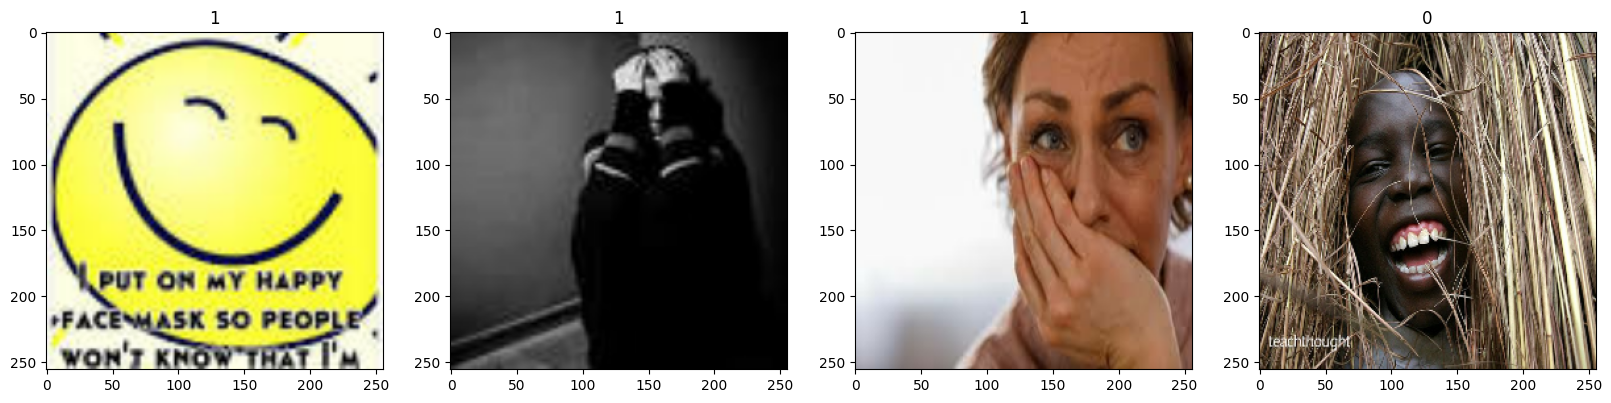

In [157]:
# vis which class belongs to happy and sad
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# 0 is for happy
# 1 is for sad

## 5. preprocessing data 

In [158]:
batch[0].max()

255.0

In [159]:
scalled = batch[0]/255
print(f"max={scalled.max()}, min={scalled.min()}")

max=1.0, min=0.0


### 5.1 scalling

In [160]:
# scalling the dataset between 0 and 1 for the image class not the label class
# x is gonna be image class and y is gonna be label class
data = data.map(lambda x, y: (x/255, y))

In [161]:
scalled_iterator = data.as_numpy_iterator()

In [162]:
scalled_iterator.next()[0].max()

1.0

In [163]:
batch = scalled_iterator.next()

In [164]:
batch[0].max()

1.0

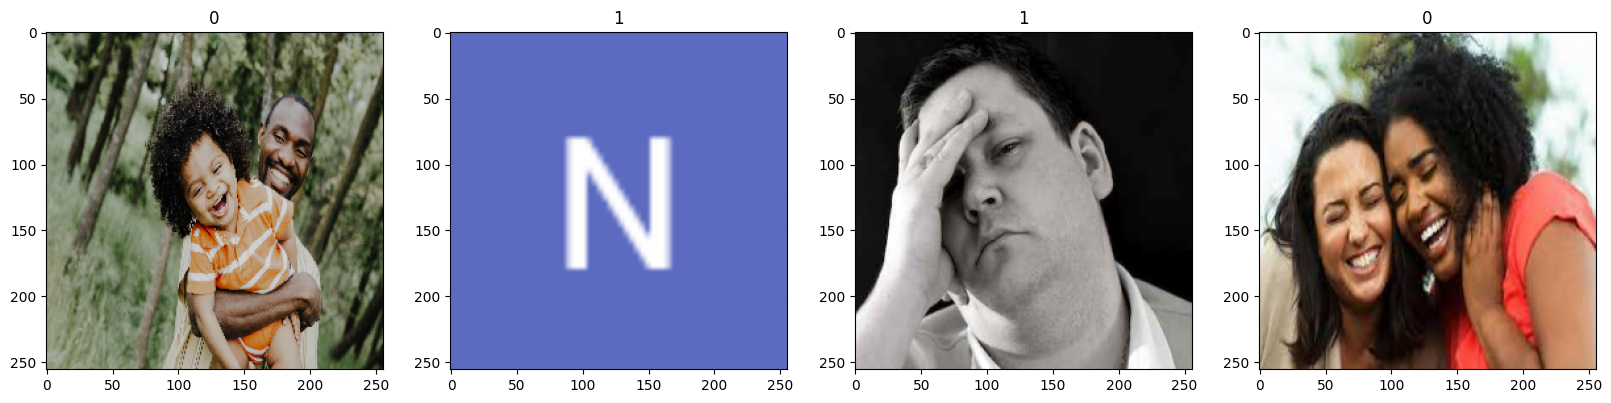

In [165]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 5.2 spliting

In [166]:
len(data) # 39 is the batch each batch has 32 images so it's 320 images

10

In [171]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [172]:
train_size

7

In [173]:
val_size

2

In [174]:
test_size

1

In [175]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [176]:
len(train),len(val),len(test)

(7, 2, 1)

## 6. Deeplearning model

### 6.1 libraries 

In [177]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

### 6.2 model building

In [178]:
model = Sequential()

In [179]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [180]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [181]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

### 6.3 training the model

In [182]:
logdir = 'logs'

In [183]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [184]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 1.3997 - accuracy: 0.5134 - val_loss: 0.6513 - val_accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 14s 2s/step - loss: 0.6841 - accuracy: 0.5402 - val_loss: 0.6855 - val_accuracy: 0.4219
Epoch 3/20
7/7 [==============================] - 14s 2s/step - loss: 0.6604 - accuracy: 0.5848 - val_loss: 0.6187 - val_accuracy: 0.7812
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 0.5695 - accuracy: 0.7991 - val_loss: 0.4864 - val_accuracy: 0.7188
Epoch 5/20
7/7 [==============================] - 14s 2s/step - loss: 0.4604 - accuracy: 0.7902 - val_loss: 0.3822 - val_accuracy: 0.8594
Epoch 6/20
7/7 [==============================] - 16s 2s/step - loss: 0.4108 - accuracy: 0.8304 - val_loss: 0.3583 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 15s 2s/step - loss: 0.3271 - accuracy: 0.8705 - val_loss: 0.2327 - val_accuracy: 0.9219
Epoch 8/20
7/7 [==================

In [185]:
hist.history

{'loss': [1.3996819257736206,
  0.6841484904289246,
  0.6603775024414062,
  0.5695040822029114,
  0.4604172110557556,
  0.4108130633831024,
  0.3271257281303406,
  0.2072976678609848,
  0.20802409946918488,
  0.20276568830013275,
  0.14257480204105377,
  0.06926143914461136,
  0.06177011877298355,
  0.03256644681096077,
  0.03576433286070824,
  0.019258646294474602,
  0.01865803636610508,
  0.016998426988720894,
  0.007286142557859421,
  0.007865185849368572],
 'accuracy': [0.5133928656578064,
  0.5401785969734192,
  0.5848214030265808,
  0.7991071343421936,
  0.7901785969734192,
  0.8303571343421936,
  0.8705357313156128,
  0.9241071343421936,
  0.9241071343421936,
  0.9419642686843872,
  0.9732142686843872,
  0.9910714030265808,
  0.9821428656578064,
  0.9866071343421936,
  0.9866071343421936,
  0.9955357313156128,
  0.9910714030265808,
  0.9910714030265808,
  1.0,
  1.0],
 'val_loss': [0.6512695550918579,
  0.685465931892395,
  0.6186926364898682,
  0.48642557859420776,
  0.38224261

### 6.4 plot performance

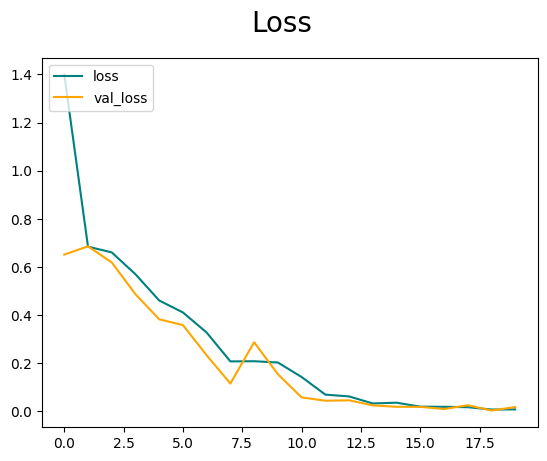

In [186]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

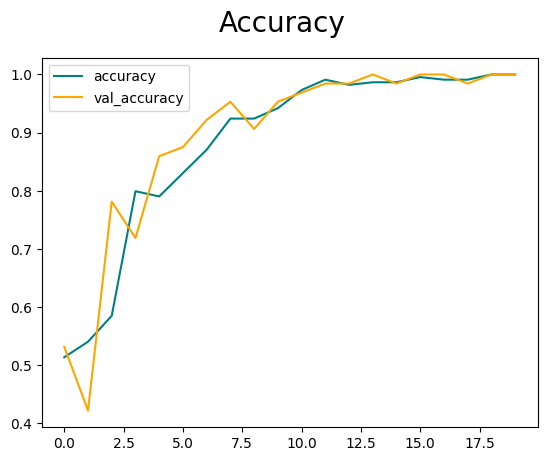

In [187]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## 7. Evaluate performance

### 7.1 evaluate

In [188]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [189]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [190]:
len(test)

1

In [192]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 630ms/step


In [197]:
print(f"precission: {pre.result().numpy()}, recall: {re.result().numpy()}, accuracy: {acc.result().numpy()}")

precission: 1.0, recall: 1.0, accuracy: 1.0


## 8. Testing 

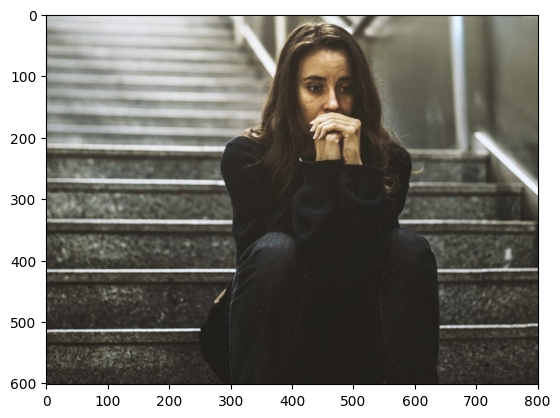

In [261]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

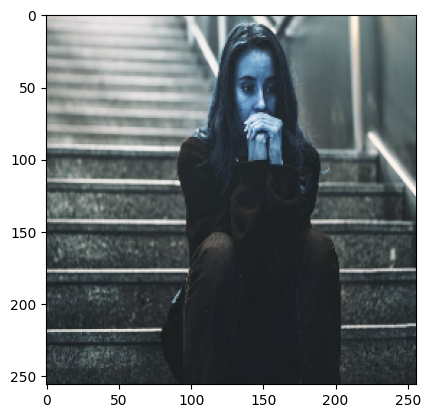

In [262]:
resize = tf.image.resize(img, (256, 256))
#plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [263]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 87ms/step


In [264]:
yhat

array([[0.9823801]], dtype=float32)

In [265]:
if yhat > 0.5:
    print("Predicted class is sad")
else:
    print("Predicted class is happy")

Predicted class is sad


## 9. Save the model

### 9.1 save the model

In [267]:
from tensorflow.keras.models import load_model

In [268]:
model.save(os.path.join('models','happysadmodel.h5'))

### 9.2 reload the model

In [269]:
new_model = load_model(os.path.join('models','happysadmodel.h5'))